In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings('ignore')

In [2]:
columns=['Customer Number', 'Offer Accepted', 'Reward', 'Mailer Type', 'Income Level','Bank Accounts Open', \
         'Overdraft Protection', 'Credit Rating','Credit Cards Held', 'Homes Owned', 'Household Size', \
         'Own Your Home', 'Average Balance', 'Q1 Balance', 'Q2 Balance',  'Q3 Balance', 'Q4 Balance']

In [3]:
df_init = pd.read_csv('./files/creditcardmarketing.csv', names=columns)
df_init.head(3)

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,Bank Accounts Open,Overdraft Protection,Credit Rating,Credit Cards Held,Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


In [4]:
class CustomInitialDataCleaner:
    def __init__(self):
        pass
    
    def __remove_duplicates(self, X):
        return X[~X.duplicated()]
    
    def __standardize_feature_headers(self, X):
        X.columns = [col.lower().replace(' ', '_') for col in X.columns]
        return X
        
    def clean(self, X):
        X = self.__remove_duplicates(X)
        return self.__standardize_feature_headers(X)

In [5]:
cleaner = CustomInitialDataCleaner()
df = cleaner.clean(df_init)
df.set_index('customer_number', inplace=True)
df.head(3)

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


In [6]:
df.isna().sum()
# just for now TODO: improve the handling here
df.fillna(0, inplace=True)
df.isna().sum()

offer_accepted          0
reward                  0
mailer_type             0
income_level            0
bank_accounts_open      0
overdraft_protection    0
credit_rating           0
credit_cards_held       0
homes_owned             0
household_size          0
own_your_home           0
average_balance         0
q1_balance              0
q2_balance              0
q3_balance              0
q4_balance              0
dtype: int64

## EDA

In [7]:
df.select_dtypes('object').apply(lambda col: col.unique())

offer_accepted                               [No, Yes]
reward                  [Air Miles, Cash Back, Points]
mailer_type                         [Letter, Postcard]
income_level                       [High, Medium, Low]
overdraft_protection                         [No, Yes]
credit_rating                      [High, Medium, Low]
own_your_home                                [No, Yes]
dtype: object

In [8]:
df['offer_accepted'].value_counts() / df.shape[0] * 100

No     94.316667
Yes     5.683333
Name: offer_accepted, dtype: float64

In [9]:
df['offer_accepted'].value_counts() 

No     16977
Yes     1023
Name: offer_accepted, dtype: int64

### Check for outliers

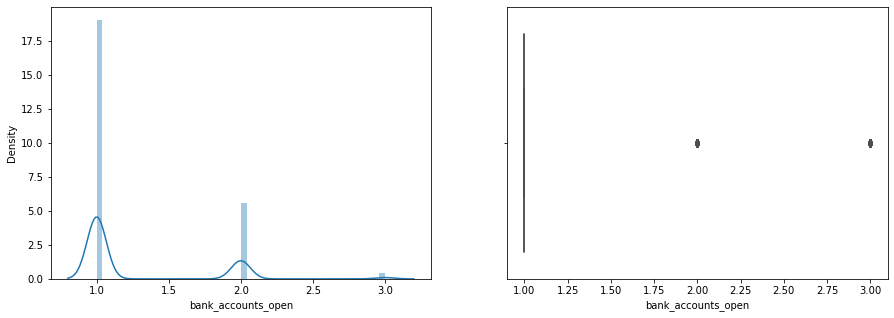

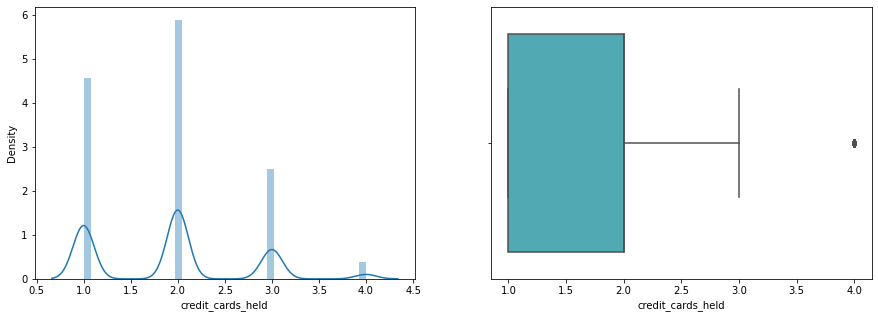

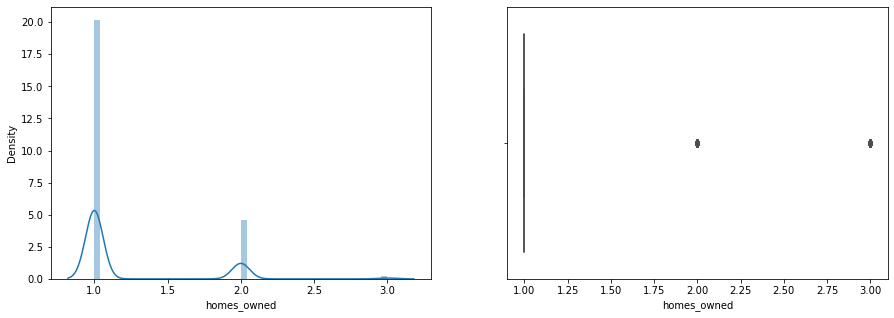

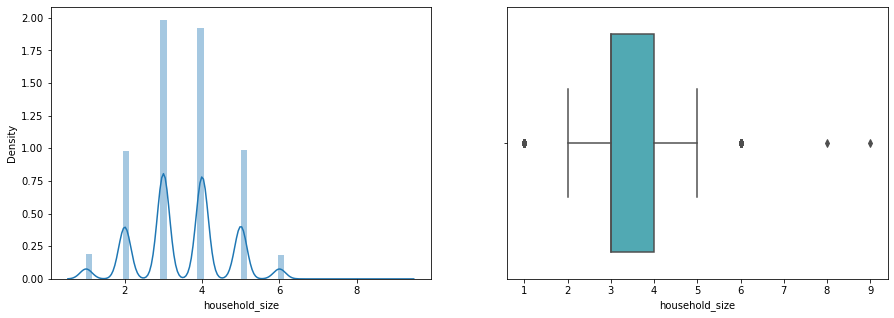

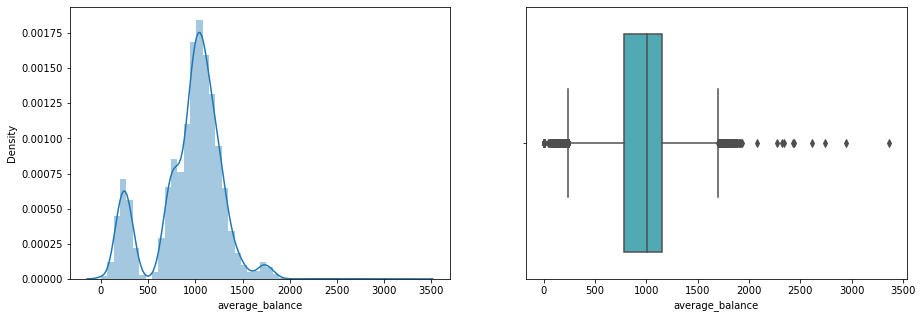

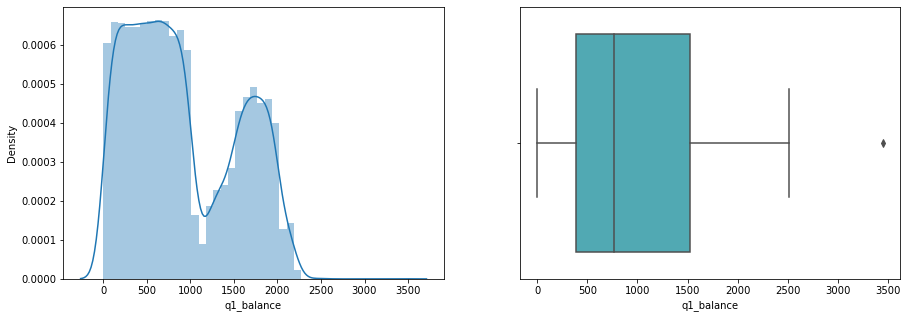

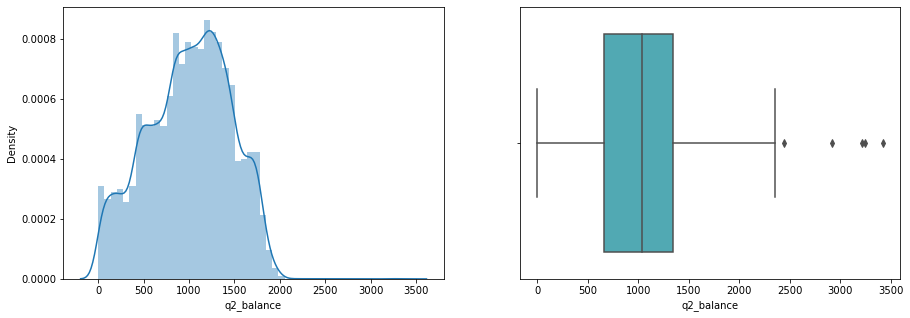

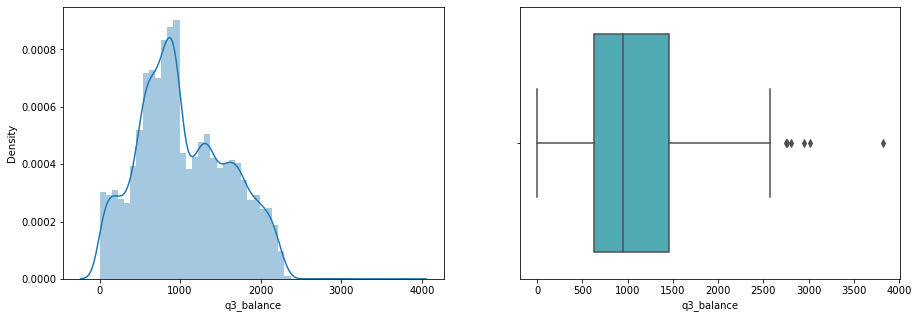

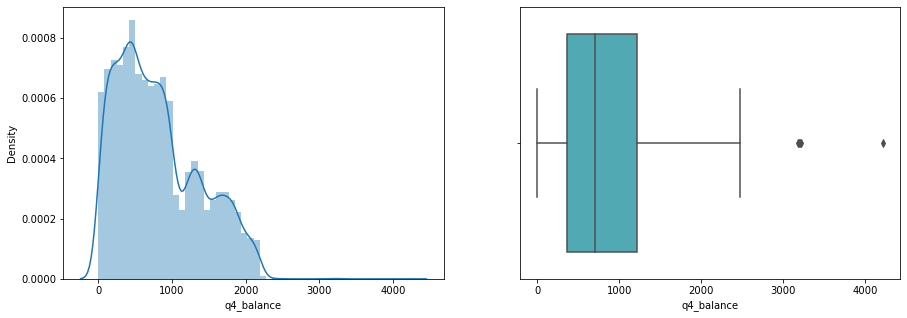

In [10]:
for col in df.select_dtypes('number'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.distplot(df[col], ax=ax[0])

    sns.boxplot(x=df[col], data=df, palette='YlGnBu', ax=ax[1])
    plt.show()
    

In [11]:
# TODO add outlier handling - prob in pipeline

## Data Preprocessing

In [12]:
# split data before any tranformations
X = df.drop('offer_accepted', axis=1, inplace=False)
y = df['offer_accepted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
numerical = df.select_dtypes('number')
categorical = df.select_dtypes('object').drop('offer_accepted', axis=1, inplace=False)
cat_ordinal_features = categorical[['income_level', 'credit_rating']].columns
cat_onehot_features = categorical.loc[:, ~categorical.columns.isin(cat_ordinal_features)].columns

# custom function to create pipelines with flexible scaler, sampler (to balance classes), and model
def make_custom_pipeline(scaler, sampler, model):
    custom_pipeline = Pipeline(
    [('scaling', ColumnTransformer([
        ('numerical', scaler, numerical.columns),
        ('cat_onehot', OneHotEncoder(sparse=False), cat_onehot_features),
        ('cat_ordinal', OrdinalEncoder(categories=[['Low', 'Medium', 'High'], \
                                                   ['Low', 'Medium', 'High']]), cat_ordinal_features),])),
     ('sampling', sampler),
     ('model', model)
     ])
    
    return custom_pipeline

#### Compare different models:

#### LogisticRegression

In [14]:
# create pipeline with scaler=StandardScaler, sampler=SMOTE, model=LogisticRegression
logreg_sdtscaler_smote = make_custom_pipeline(StandardScaler(), SMOTE(), LogisticRegression(random_state=42, 
                                                                                            max_iter=10000))
logreg_sdtscaler_smote.fit(X_train, y_train);

In [15]:
logreg_sdtscaler_ros = make_custom_pipeline(StandardScaler(), RandomOverSampler(random_state=42), 
                                              LogisticRegression(random_state=42, max_iter=10000))
logreg_sdtscaler_ros.fit(X_train, y_train);

In [16]:
logreg_sdtscaler_rus = make_custom_pipeline(StandardScaler(), RandomUnderSampler(random_state=42), 
                                              LogisticRegression(random_state=42, max_iter=10000))
logreg_sdtscaler_rus.fit(X_train, y_train);

In [270]:
print('='*80)
print('LogisticRegression & SMOTE')
print()
print(classification_report(y_test, logreg_sdtscaler_smote.predict(X_test)))
print('='*80)
print('LogisticRegression & RandomOversmapler')
print()
print(classification_report(y_test, logreg_sdtscaler_ros.predict(X_test)))
print('='*80)
print('LogisticRegression & RandomUnderSampler')
print()
print(classification_report(y_test, logreg_sdtscaler_rus.predict(X_test)))

LogisticRegression & SMOTE

              precision    recall  f1-score   support

          No       0.98      0.68      0.80      3395
         Yes       0.12      0.72      0.20       205

    accuracy                           0.68      3600
   macro avg       0.55      0.70      0.50      3600
weighted avg       0.93      0.68      0.77      3600

LogisticRegression & RandomOversmapler

              precision    recall  f1-score   support

          No       0.98      0.66      0.79      3395
         Yes       0.12      0.74      0.20       205

    accuracy                           0.67      3600
   macro avg       0.55      0.70      0.49      3600
weighted avg       0.93      0.67      0.76      3600

LogisticRegression & RandomUnderSampler

              precision    recall  f1-score   support

          No       0.98      0.65      0.78      3395
         Yes       0.12      0.76      0.20       205

    accuracy                           0.66      3600
   macro avg       

#### KNN Classifier